In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

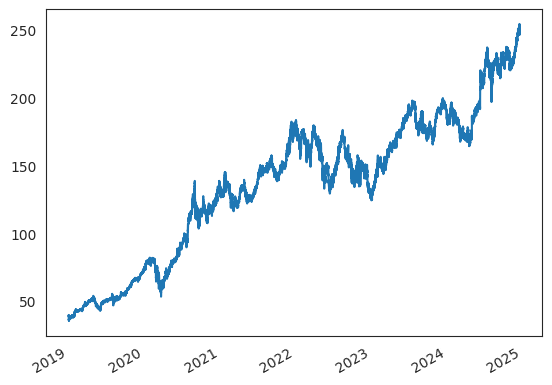

,atr_pct_7,range_pct,atr_pct_28,ret_std_63,donch_w_20,ret_std_21,atr_pct_14,time_afthour,kc_w_20_20_1.5,bb_w_20_2p0,dist_low_200,time_in_sess,donch_w_55,trade_count,bb_w_50_2p0,lower_shad,time_premark,upper_shad,dist_high_200,time_hour,volume,time_minute,time_week_of_year,sma_pct_200,atr_7_RZ,time_month,atr_14_RZ,time_day_of_year,adx_28,vol_spike_28,sma_pct_50,atr_28_RZ,roc_5,body_pct,plus_di_14,roll_vwap_20_RZ,minus_di_7,plus_di_28,plus_di_7,rolling_max_close_200_RZ,minus_di_28,sma_pct_100,minus_di_14,roc_21,ret,rolling_min_close_200_RZ,rsi_21,ema_8_RZ,vol_spike_14,macd_signal_6_13_5_RZ,close_raw,targ_signal,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,pred_signal,ask,bid
2019-01-02 08:59:00,0.594408,0.200219,0.435928,1.000000,0.252563,0.361831,0.511354,0.0,0.469876,0.213675,0.310222,0.0,0.208866,0.000552,0.144929,0.016026,1.0,0.0,0.722967,0.270833,0.002921,0.311806,0.500000,0.000000,0.215673,0.500000,0.202344,0.502740,0.516546,0.096608,0.547500,0.220587,0.361340,0.688078,0.130076,0.474357,0.014496,0.133762,0.111767,0.602940,0.200073,0.112898,0.048229,0.535401,0.438817,0.366904,0.413580,0.471218,0.098353,0.555128,38.633333,0.156838,0.121416,0.053792,29.177413,51.144962,38.604496,0.201044,38.641060,38.625607
2019-01-02 09:00:00,0.520034,0.000000,0.423157,1.000000,0.252618,0.362178,0.480298,0.0,0.450165,0.210478,0.303499,0.0,0.208914,0.000000,0.135145,0.000000,1.0,0.0,0.729733,0.312500,0.000847,0.312500,0.500000,0.000000,0.195842,0.500000,0.196702,0.502740,0.499453,0.032562,0.528605,0.219802,0.361310,0.502374,0.128201,0.474563,0.014180,0.132137,0.109421,0.602940,0.198021,0.113154,0.047414,0.532049,0.438804,0.366904,0.398528,0.470938,0.034703,0.543876,38.625000,0.228904,0.121416,0.050545,30.044487,46.202603,38.604588,0.190931,38.632725,38.617275
2019-01-02 09:01:00,0.475833,0.178249,0.416080,1.000000,0.252460,0.366486,0.461641,0.0,0.439025,0.206148,0.322651,0.0,0.161736,0.000637,0.127580,0.000000,1.0,0.0,0.710458,0.312500,0.002109,0.313194,0.500000,0.016523,0.185581,0.500000,0.195021,0.502740,0.478907,0.070749,0.567148,0.217458,0.467516,0.681708,0.165744,0.474373,0.013219,0.159907,0.168638,0.602940,0.192119,0.153161,0.045026,0.580403,0.676522,0.366904,0.450264,0.471597,0.081125,0.540164,38.648750,0.137736,0.121416,0.048631,31.549030,59.565708,38.605012,0.197606,38.656480,38.641020
2019-01-02 09:02:00,0.468651,0.356279,0.417858,1.000000,0.252301,0.332495,0.460580,0.0,0.440144,0.213320,0.341780,0.0,0.161628,0.001275,0.123566,0.000000,1.0,0.0,0.691207,0.312500,0.003372,0.313889,0.500000,0.040942,0.184386,0.500000,0.199382,0.502740,0.460489,0.107589,0.605167,0.219934,0.573768,0.861041,0.195229,0.474347,0.011393,0.181774,0.213751,0.602940,0.180610,0.192901,0.040410,0.517927,0.676414,0.366904,0.497288,0.474070,0.129021,0.547554,38.672500,0.001063,0.121416,0.048551,33.478049,68.850603,38.605995,0.208876,38.680234,38.664766
2019-01-02 09:03:00,0.454735,0.267248,0.417623,0.257173,0.252339,0.332045,0.455647,0.0,0.438129,0.219624,0.337251,0.0,0.151754,0.000956,0.120734,0.000000,1.0,0.0,0.695764,0.312500,0.002560,0.314583,0.500000,0.039567,0.181494,0.500000,0.201709,0.502740,0.442729,0.082550,0.590870,0.220456,0.582756,0.771331,0.181467,0.474349,0.009972,0.171953,0.188602,0.602940,0.171011,0.196072,0.036641,0.522289,0.458910,0.366904,0.485870,0.477835,0.102584,0.549962,38.666875,0.004157,0.121416,0.048029,35.269281,64.632490,38.606674,0.198413,38.674608,38.659142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18 23:55:00,0.072681,0.000000,0.119045,0.173271,0.039900,0.151082,0.087718,1.0,0.101193,0.042412,0.073901,0.0,0.072731,0.008414,0.074667,0.000000,0.0,0.0,0.131484,0.895833,0.003841,0.934028,0.461538,0.512824,0.109456,0.416667,0.125414,0.464384,0.000000,0.759793,0.536291,0.141305,0.509615,0.502374,0.417085,

In [3]:
###### ML STRATEGIES DF ######

df_trainval = pd.read_csv(params.pred_trainval_csv, index_col=0, parse_dates=True)

df_trainval.close_raw.plot() ; plt.show()
df_trainval

In [4]:
# # ##### 5 ######
# {'reset_peak': (1, 1),
#  'rsi_min_thresh': (21, 29),
#  'rsi_max_thresh': (60, 74),
#  'adx_thresh': (8.018379455902043, 16.03396054409796),
#  'atr_mult': (24.726563105324534, 30.726826894675465),
#  'vwap_atr_mult': (1.1320614885122513, 9.46073851148775),
#  'buy_factor': (0.31505719971993146, 0.6012728002800687),
#  'sell_factor': (-0.002279885026673041, 0.03658988502667304),
#  'trailstop_pct': (30.294243131720588, 36.21820686827942),
#  'thresh_choice': {'categorical': ['roll_p90']},
#  'thresh_window': (9.428644689126353, 20.57135531087365)}


In [5]:
col_signal = "pred_signal"

prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [True, False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 20, 30)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 55), 80)
    adx_thresh       = trial.suggest_float("adx_thresh", 8.0, 16.0)
    atr_mult         = trial.suggest_float("atr_mult", 23, 32, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 1, 10)
    buy_factor       = trial.suggest_float("buy_factor", 0.3, 0.6)
    sell_factor      = trial.suggest_float("sell_factor", 0.001, 0.1)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 20.0, 40.0)
    thresh_choice = trial.suggest_categorical("thresh_choice",
        ["roll_p90"])

    if thresh_choice == "numeric":
        thresh_mode = trial.suggest_float("thresh_value", 0.3, 3)
        thresh_window = None
    else: # signal threshold
        thresh_mode = thresh_choice
        thresh_window = trial.suggest_int("thresh_window", 5, 30) if thresh_choice.startswith("roll") else None

    print('-' * 160)
    print("TRIAL "+trial.number+" Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))
    
    df_thresh = preps.apply_thresholds_per_day(
        df = df_trainval.copy(),
        col_signal = col_signal,  
        thresh_mode = thresh_mode,
        thresh_window = thresh_window,
    )

    start_ask = df_thresh.loc[df_thresh.index.normalize() == df_thresh.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0

    groups = df_thresh.groupby(df_thresh.index.normalize())
    pbar = tqdm(groups, desc=f"Gen&Sim", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = col_signal,
            sign_thresh     = "signal_thresh",
            col_atr         = 'atr_14_raw',
            col_adx         = 'adx_14_raw',
            col_rsi         = 'rsi_6_raw',
            col_vwap        = 'vwap_ohlc_close_session_raw',
            col_close       = 'close_raw',
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: 359.1133


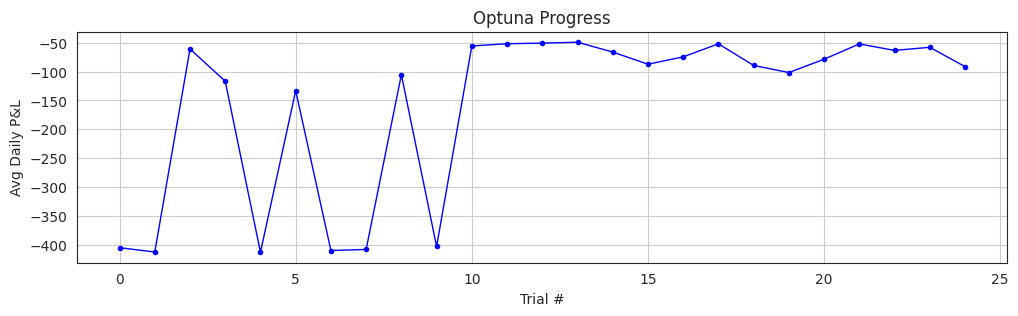

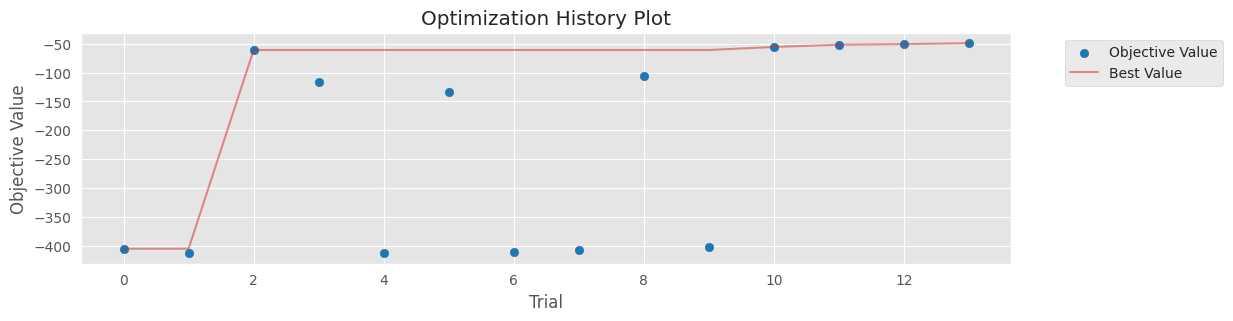

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=596; adx_thresh=13.208830269564078; atr_mult=28.33746840229387; vwap_atr_mult=8.659648016125157; buy_factor=0.3649753505005778; sell_factor=0.08987637349806095; trailstop_pct=38.98819163951333; thresh_choice=roll_p90; thresh_window=24


Trial 0: 100%|██████████| 1502/1502 [01:13<00:00, 20.43it/s]       


[Results] mean_pnl:-44.1532 mean_bh:360.4674 mean_excess:-404.6205 improv_vs_bh:-112.25%
Action counts: {'Buy': 29488, 'Sell': 75890, 'Hold': 1217972}
Best trial is: 0 with best_val: -404.6205
[save_results] wrote optuna_results/AAPL_-404.6205_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-404.6205_pred_ML.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=322; adx_thresh=8.0506695193681; atr_mult=27.096360527892266; vwap_atr_mult=5.4051757577427715; buy_factor=0.5327621559691132; sell_factor=0.058468113008509015; trailstop_pct=23.808909919792548; thresh_choice=roll_p90; thresh_window=26


Trial 1: 100%|██████████| 1502/1502 [01:12<00:00, 20.65it/s]       


[Results] mean_pnl:-51.6134 mean_bh:360.4674 mean_excess:-412.0808 improv_vs_bh:-114.32%
Action counts: {'Buy': 26331, 'Sell': 83629, 'Hold': 1213390}
Best trial is: 0 with best_val: -404.6205
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=221; adx_thresh=15.74840983884701; atr_mult=27.546598786011486; vwap_atr_mult=3.7795005463603415; buy_factor=0.5230207220423897; sell_factor=0.0029380763833784917; trailstop_pct=20.47983419119297; thresh_choice=roll_p90; thresh_window=10


Trial 2: 100%|██████████| 1502/1502 [01:09<00:00, 21.62it/s]       


[Results] mean_pnl:299.4063 mean_bh:360.4674 mean_excess:-61.0611 improv_vs_bh:-16.94%
Action counts: {'Buy': 12104, 'Sell': 2012, 'Hold': 1309234}
Best trial is: 2 with best_val: -61.0611
[save_results] wrote optuna_results/AAPL_-61.0611_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-61.0611_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=245; adx_thresh=13.183545055841677; atr_mult=28.22861151330328; vwap_atr_mult=9.825299068348249; buy_factor=0.5366050579647434; sell_factor=0.013273884876534841; trailstop_pct=34.68606553643602; thresh_choice=roll_p90; thresh_window=29


Trial 3: 100%|██████████| 1502/1502 [00:59<00:00, 25.45it/s]       


[Results] mean_pnl:243.6895 mean_bh:360.4674 mean_excess:-116.7779 improv_vs_bh:-32.40%
Action counts: {'Buy': 11967, 'Sell': 1974, 'Hold': 1309409}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=756; adx_thresh=11.21986955324079; atr_mult=28.625725150119266; vwap_atr_mult=7.704771587355803; buy_factor=0.37657811871699015; sell_factor=0.002381885777463436; trailstop_pct=37.04591621611902; thresh_choice=roll_p90; thresh_window=12


Trial 4: 100%|██████████| 1502/1502 [01:14<00:00, 20.10it/s]       


[Results] mean_pnl:-51.9728 mean_bh:360.4674 mean_excess:-412.4402 improv_vs_bh:-114.42%
Action counts: {'Buy': 36787, 'Sell': 97731, 'Hold': 1188832}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=232; adx_thresh=12.678710530450967; atr_mult=23.399481015090956; vwap_atr_mult=2.8159627495980764; buy_factor=0.5695627758327743; sell_factor=0.008121421897217998; trailstop_pct=30.270379899206763; thresh_choice=roll_p90; thresh_window=28


Trial 5: 100%|██████████| 1502/1502 [01:00<00:00, 24.77it/s]       


[Results] mean_pnl:227.3568 mean_bh:360.4674 mean_excess:-133.1106 improv_vs_bh:-36.93%
Action counts: {'Buy': 13663, 'Sell': 2417, 'Hold': 1307270}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; adx_thresh=13.514559296131907; atr_mult=24.604692372716837; vwap_atr_mult=1.220049453540728; buy_factor=0.5338494928333108; sell_factor=0.07445794316661641; trailstop_pct=32.75044923851482; thresh_choice=roll_p90; thresh_window=20


Trial 6: 100%|██████████| 1502/1502 [01:11<00:00, 21.00it/s]       


[Results] mean_pnl:-49.0251 mean_bh:360.4674 mean_excess:-409.4925 improv_vs_bh:-113.60%
Action counts: {'Buy': 24855, 'Sell': 88469, 'Hold': 1210026}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=125; adx_thresh=11.22003601433817; atr_mult=27.509395231333333; vwap_atr_mult=6.459776608655711; buy_factor=0.5847039578717756; sell_factor=0.05978467743629645; trailstop_pct=36.21716307232076; thresh_choice=roll_p90; thresh_window=29


Trial 7: 100%|██████████| 1502/1502 [01:08<00:00, 21.85it/s]       


[Results] mean_pnl:-47.1584 mean_bh:360.4674 mean_excess:-407.6258 improv_vs_bh:-113.08%
Action counts: {'Buy': 22855, 'Sell': 77546, 'Hold': 1222949}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=275; adx_thresh=12.36042051048114; atr_mult=24.046795149979253; vwap_atr_mult=3.2460300351201536; buy_factor=0.3724578035895913; sell_factor=0.04095069317790487; trailstop_pct=24.3239843486022; thresh_choice=roll_p90; thresh_window=16


Trial 8: 100%|██████████| 1502/1502 [01:08<00:00, 22.07it/s]       


[Results] mean_pnl:255.0369 mean_bh:360.4674 mean_excess:-105.4304 improv_vs_bh:-29.25%
Action counts: {'Buy': 20461, 'Sell': 2341, 'Hold': 1300548}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=646; adx_thresh=12.193180650358148; atr_mult=31.689714371088467; vwap_atr_mult=2.2417904287162465; buy_factor=0.3972053430619175; sell_factor=0.09993789305468416; trailstop_pct=29.427021691403766; thresh_choice=roll_p90; thresh_window=20


Trial 9: 100%|██████████| 1502/1502 [01:17<00:00, 19.29it/s]       


[Results] mean_pnl:-42.0689 mean_bh:360.4674 mean_excess:-402.5362 improv_vs_bh:-111.67%
Action counts: {'Buy': 25632, 'Sell': 72537, 'Hold': 1225181}
Best trial is: 2 with best_val: -61.0611
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=460; adx_thresh=15.895291876589708; atr_mult=25.66370939674159; vwap_atr_mult=5.008830492877604; buy_factor=0.46283643395428886; sell_factor=0.030612798523637394; trailstop_pct=20.02866942111019; thresh_choice=roll_p90; thresh_window=6


Trial 10: 100%|██████████| 1502/1502 [01:06<00:00, 22.53it/s]      


[Results] mean_pnl:304.6625 mean_bh:360.4674 mean_excess:-55.8049 improv_vs_bh:-15.48%
Action counts: {'Buy': 17729, 'Sell': 2180, 'Hold': 1303441}
Best trial is: 10 with best_val: -55.8049
[save_results] wrote optuna_results/AAPL_-55.8049_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-55.8049_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=462; adx_thresh=15.923687472543312; atr_mult=25.653818287928726; vwap_atr_mult=4.6118231325807075; buy_factor=0.4662102768541623; sell_factor=0.031191594057548455; trailstop_pct=20.371484947968483; thresh_choice=roll_p90; thresh_window=5


Trial 11: 100%|██████████| 1502/1502 [01:01<00:00, 24.25it/s]      


[Results] mean_pnl:308.4979 mean_bh:360.4674 mean_excess:-51.9695 improv_vs_bh:-14.42%
Action counts: {'Buy': 17824, 'Sell': 2181, 'Hold': 1303345}
Best trial is: 11 with best_val: -51.9695
[save_results] wrote optuna_results/AAPL_-51.9695_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-51.9695_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=464; adx_thresh=15.944208837030391; atr_mult=25.530833059449144; vwap_atr_mult=4.978247724457868; buy_factor=0.4519481391505706; sell_factor=0.03233764431776089; trailstop_pct=21.42673371742971; thresh_choice=roll_p90; thresh_window=5


Trial 12: 100%|██████████| 1502/1502 [01:03<00:00, 23.66it/s]      
/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


[Results] mean_pnl:309.5661 mean_bh:360.4674 mean_excess:-50.9012 improv_vs_bh:-14.12%
Action counts: {'Buy': 18590, 'Sell': 2194, 'Hold': 1302566}
Best trial is: 12 with best_val: -50.9012
[save_results] wrote optuna_results/AAPL_-50.9012_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-50.9012_pred_ML.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=472; adx_thresh=14.62393052629947; atr_mult=25.798452791506246; vwap_atr_mult=4.359315890477213; buy_factor=0.44471034218889904; sell_factor=0.025198167253882187; trailstop_pct=24.658304617451094; thresh_choice=roll_p90; thresh_window=5


Trial 13: 100%|██████████| 1502/1502 [01:06<00:00, 22.67it/s]      


[Results] mean_pnl:311.1164 mean_bh:360.4674 mean_excess:-49.3510 improv_vs_bh:-13.69%
Action counts: {'Buy': 18384, 'Sell': 2170, 'Hold': 1302796}
Best trial is: 13 with best_val: -49.3510
[save_results] wrote optuna_results/AAPL_-49.351_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-49.351_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=554; adx_thresh=14.557989555293588; atr_mult=25.738686697657766; vwap_atr_mult=6.710199646511205; buy_factor=0.42452807464649284; sell_factor=0.02368776080506926; trailstop_pct=25.69714290288379; thresh_choice=roll_p90; thresh_window=9


Trial 14: 100%|██████████| 1502/1502 [01:07<00:00, 22.21it/s]      


[Results] mean_pnl:294.1297 mean_bh:360.4674 mean_excess:-66.3377 improv_vs_bh:-18.40%
Action counts: {'Buy': 17671, 'Sell': 2177, 'Hold': 1303502}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=379; adx_thresh=14.602527320430154; atr_mult=29.77391117866208; vwap_atr_mult=4.212930437821278; buy_factor=0.3065622641709272; sell_factor=0.04164500025755245; trailstop_pct=27.598426032925367; thresh_choice=roll_p90; thresh_window=14


Trial 15: 100%|██████████| 1502/1502 [01:02<00:00, 24.10it/s]      


[Results] mean_pnl:273.1003 mean_bh:360.4674 mean_excess:-87.3671 improv_vs_bh:-24.24%
Action counts: {'Buy': 19440, 'Sell': 1860, 'Hold': 1302050}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=508; adx_thresh=14.502558296648992; atr_mult=26.36630909273507; vwap_atr_mult=6.4652314088621985; buy_factor=0.49003843360983684; sell_factor=0.04794385289573144; trailstop_pct=23.192451032092883; thresh_choice=roll_p90; thresh_window=8


Trial 16: 100%|██████████| 1502/1502 [00:59<00:00, 25.18it/s]      


[Results] mean_pnl:285.7709 mean_bh:360.4674 mean_excess:-74.6965 improv_vs_bh:-20.72%
Action counts: {'Buy': 15661, 'Sell': 2124, 'Hold': 1305565}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=718; adx_thresh=9.932938545092917; atr_mult=24.71369922719149; vwap_atr_mult=5.781501471416763; buy_factor=0.43774867970157016; sell_factor=0.019658164812564147; trailstop_pct=26.57763842477414; thresh_choice=roll_p90; thresh_window=5


Trial 17: 100%|██████████| 1502/1502 [00:59<00:00, 25.36it/s]      


[Results] mean_pnl:308.3772 mean_bh:360.4674 mean_excess:-52.0901 improv_vs_bh:-14.45%
Action counts: {'Buy': 19353, 'Sell': 2271, 'Hold': 1301726}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=380; adx_thresh=15.00342660261029; atr_mult=23.375502768251884; vwap_atr_mult=1.8120094380248863; buy_factor=0.3153914519944299; sell_factor=0.03209200096229855; trailstop_pct=22.510890501359356; thresh_choice=roll_p90; thresh_window=11


Trial 18: 100%|██████████| 1502/1502 [00:58<00:00, 25.75it/s]      


[Results] mean_pnl:270.9405 mean_bh:360.4674 mean_excess:-89.5268 improv_vs_bh:-24.84%
Action counts: {'Buy': 24860, 'Sell': 2410, 'Hold': 1296080}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=659; adx_thresh=14.234340502119009; atr_mult=24.84042751109927; vwap_atr_mult=7.631171759165172; buy_factor=0.4158979450860051; sell_factor=0.05619263654844156; trailstop_pct=28.417220030607876; thresh_choice=roll_p90; thresh_window=14


Trial 19: 100%|██████████| 1502/1502 [00:56<00:00, 26.80it/s]      


[Results] mean_pnl:258.6739 mean_bh:360.4674 mean_excess:-101.7935 improv_vs_bh:-28.24%
Action counts: {'Buy': 18815, 'Sell': 2262, 'Hold': 1302273}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=540; adx_thresh=15.28421038819802; atr_mult=26.467625436218633; vwap_atr_mult=3.8347376810022036; buy_factor=0.4984353949151013; sell_factor=0.0710430569843295; trailstop_pct=31.839198574294667; thresh_choice=roll_p90; thresh_window=7


Trial 20: 100%|██████████| 1502/1502 [00:56<00:00, 26.48it/s]      


[Results] mean_pnl:281.6775 mean_bh:360.4674 mean_excess:-78.7899 improv_vs_bh:-21.86%
Action counts: {'Buy': 15722, 'Sell': 2109, 'Hold': 1305519}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=460; adx_thresh=15.828121858355997; atr_mult=25.559647109201517; vwap_atr_mult=4.716907645306397; buy_factor=0.4632684486627032; sell_factor=0.03207108001595818; trailstop_pct=21.21346508376158; thresh_choice=roll_p90; thresh_window=5


Trial 21: 100%|██████████| 1502/1502 [00:57<00:00, 26.10it/s]      


[Results] mean_pnl:308.1558 mean_bh:360.4674 mean_excess:-52.3116 improv_vs_bh:-14.51%
Action counts: {'Buy': 18079, 'Sell': 2191, 'Hold': 1303080}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=359; adx_thresh=13.946607428638933; atr_mult=26.4392392835197; vwap_atr_mult=4.604313620573446; buy_factor=0.466086724264731; sell_factor=0.02061386125803049; trailstop_pct=21.721899680531187; thresh_choice=roll_p90; thresh_window=8


Trial 22: 100%|██████████| 1502/1502 [00:57<00:00, 26.07it/s]      


[Results] mean_pnl:296.9423 mean_bh:360.4674 mean_excess:-63.5251 improv_vs_bh:-17.62%
Action counts: {'Buy': 16186, 'Sell': 2113, 'Hold': 1305051}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=452; adx_thresh=15.405663943862574; atr_mult=25.28406129079504; vwap_atr_mult=5.5192376366347276; buy_factor=0.49908383994698857; sell_factor=0.039987077842318; trailstop_pct=25.292013897491056; thresh_choice=roll_p90; thresh_window=5


Trial 23: 100%|██████████| 1502/1502 [01:01<00:00, 24.52it/s]      


[Results] mean_pnl:302.3351 mean_bh:360.4674 mean_excess:-58.1323 improv_vs_bh:-16.13%
Action counts: {'Buy': 16110, 'Sell': 2216, 'Hold': 1305024}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=503; adx_thresh=15.058940799074124; atr_mult=23.848005495891957; vwap_atr_mult=2.69234552794075; buy_factor=0.44360278451270124; sell_factor=0.026204315554117844; trailstop_pct=22.324832786621137; thresh_choice=roll_p90; thresh_window=13


Trial 24: 100%|██████████| 1502/1502 [00:57<00:00, 25.94it/s]      


[Results] mean_pnl:268.9402 mean_bh:360.4674 mean_excess:-91.5272 improv_vs_bh:-25.39%
Action counts: {'Buy': 18204, 'Sell': 2364, 'Hold': 1302782}
Best trial is: 13 with best_val: -49.3510
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=406; adx_thresh=15.99317884201323; atr_mult=26.15633397714734; vwap_atr_mult=3.682333157010767; buy_factor=0.48353092878442144; sell_factor=0.014416886397253383; trailstop_pct=25.220496209075915; thresh_choice=roll_p90; thresh_window=10


KeyboardInterrupt: 

In [6]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_trainval.loc[df_trainval.index.normalize() == df_trainval.index.normalize().min(), "ask"].iat[0]
end   = df_trainval.loc[df_trainval.index.normalize() == df_trainval.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_trainval.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

n_days = df_trainval.index.normalize().nunique()
reports_per_trial = math.ceil(n_days / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)


# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("pred_ML")
cb_save_json = opts.make_save_best_json_callback("pred_ML")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()

In [9]:
# A: precompute once
df_thresh_A = preps.apply_thresholds_per_day(df_trainval.copy(), col_signal='pred_signal',
                                       thresh_mode='roll_p90', thresh_window=20)

# B: compute per-day inside loop and concat
parts = []
for day, day_df in df_trainval.groupby(df_trainval.index.normalize()):
    parts.append(preps.apply_thresholds_per_day(day_df.copy(), col_signal='pred_signal',
                                          thresh_mode='roll_p90', thresh_window=20))
df_thresh_B = pd.concat(parts).sort_index()

# Compare
assert df_thresh_A['signal_thresh'].equals(df_thresh_B['signal_thresh'])
print("Equal:", df_thresh_A['signal_thresh'].equals(df_thresh_B['signal_thresh']))


Equal: True
